#COVID-19 Full Text Article KeyPhrase Extraction

Keyphrase extraction is a textual information processing task concerned with the automatic extraction of representative and characteristic phrases from a document that express all the key aspects of its content. Keyphrases constitute a succinct conceptual summary of a document, which is very useful in digital information management systems for semantic indexing, faceted search, document clustering and classification.

There exist both supervised and unsupervised keyphrase extraction methods. Unsupervised methods are popular because they are domain independent and do not need labeled training data  so I use  unsupervised methode.
The most important merit of unsupervised models is that they can work in a new area or language with little or no adjustments. We can divide the unsupervised techniques into two subsets statistical models  and graphbased models 

**Statistical models:** are models that select candidates based on their statistical features Such as TF and IDF,Sentence Position, Word Position and etc.  The most popular statistical  algorithm is TFIDF, Kpminer, Yake and etc.

**Graph-based Models:** These approaches typically consist of two steps: (1) building a graph representation of the document with words as nodes and semantic relation between them as edges; (2) ranking nodes using a graph-theoretic measure and using the top-ranked ones as keyphrases .The most popular Graph-based   algorithm is Text Rank, Single Rank, Topic Rank, Multipartiti Rank, Scake and etc.
Most of unsupervised  models are implemented using PKE (an open source python-based keyphrase extraction toolkit) and I use PKE toolkit

**Which unsupervised  algorithm  is best for Covid-19 Full Text Article ?**

Based my experience and test in  multipe keyphrase extraction dataset that contain long  scientific text for example Krapavin, semeval 2010, Nguyen, statistical Models result is better than Graph based models also when we use each dataset DF  count in kpminer algorithm. the results make a significant improvement from other algorithms. So we use Kpminer algorithm for this task purpose. Also we use genism phrase for better bigram and trigram candid phrase detection. first we train genism phrase  based on all covid-19 article for detect commen phrase in this domain  article then we use trained model for detect commen phrase in each article and normal ngram for specific phrase in article.

In the fellow we shown my tests in Keyphrase Extraction Dataset.
for kpminer algorithm use DF of each article and use my prposed way for candid phrase detection.
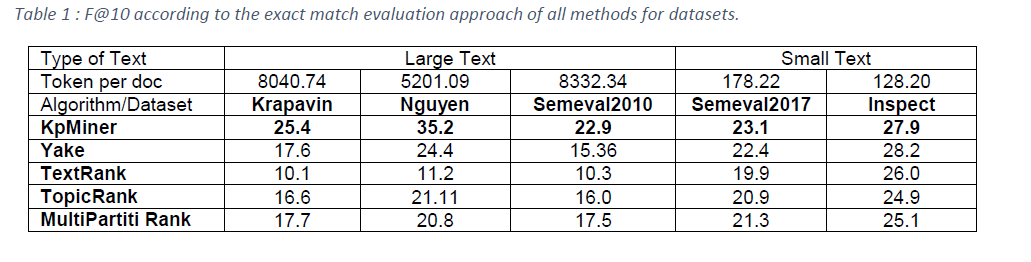


# Prepare Data
**Note : I use output of cord-19 eda parse json and generate csv file notbook in my work**

Then i concatenate all 3 FullText Articles csv Files 

In [ ]:
import pandas as pd

pmc = pd.read_csv('../input/cord-19-eda-parse-json-and-generate-clean-csv/clean_pmc.csv', delimiter=',', encoding='utf-8')
noncommon = pd.read_csv('../input/cord-19-eda-parse-json-and-generate-clean-csv/clean_noncomm_use.csv', delimiter=',', encoding='utf-8')
common_use = pd.read_csv('../input/cord-19-eda-parse-json-and-generate-clean-csv/clean_comm_use.csv', delimiter=',', encoding='utf-8')

In [ ]:
frames  = [pmc[['paper_id','title','abstract','text']],noncommon[['paper_id','title','abstract','text']],common_use[['paper_id','title','abstract','text']]]
articles = pd.concat(frames)
articles.head(5)


In [ ]:
# install pke for keyphrase extraction
!pip install git+https://github.com/boudinfl/pke.git

# Kpminer Compute Covid-19 Articles words DF 
Compute Document Frequency (DF) counts from a collection of documents. 
N-grams up to 3-grams are extracted and converted to their n-stems forms.
Those containing a token that occurs in a stoplist are filtered out.
Output file is in compressed (gzip) tab-separated-values format (tsv.gz)

In [ ]:
from pke.base import LoadFile
from string import punctuation
from nltk.corpus import stopwords
import string
from collections import defaultdict
import os
import sys
import gzip

stoplist = list(stopwords.words('english')) + list(string.punctuation)


frequencies = defaultdict(int)
delimiter='\t'

# initialize number of documents
nb_documents = 0


#Note: im limit this item becuase is very time consumed task for my notebook
limite_dataset_article = 50
if limite_dataset_article is not None:
    my_df_articles = articles.head(limite_dataset_article)
else :
    my_df_articles = articles

output_file = 'df.tsv.gz'
for index,article in my_df_articles.iterrows():
    content = str(article.title) + ' ' + str(article.abstract) + ' '+str(article.text)
    doc = LoadFile()
    doc.load_document(input=str(content))
    # n is number of n-gram
    doc.ngram_selection(n=3)
    doc.candidate_filtering(stoplist=stoplist)
     # loop through candidates
    for lexical_form in doc.candidates:
        frequencies[lexical_form] += 1
    nb_documents += 1

    if nb_documents % 10 == 0:
        print("{} docs, memory used: {} mb".format(nb_documents,
                                                          sys.getsizeof(
                                                              frequencies)
                                                          / 1024 / 1024))
# create directories from path if not exists
if os.path.dirname(output_file):
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

# dump the df container
with gzip.open(output_file, 'wb') as f:
    # add the number of documents as special token
    first_line = '--NB_DOC--' + delimiter + str(nb_documents)
    f.write(first_line.encode('utf-8') + b'\n')
    for ngram in frequencies:
        line = ngram + delimiter + str(frequencies[ngram])
        f.write(line.encode('utf-8') + b'\n')



After computing document frequency file use df file in kpminer algorithm

In [ ]:
from pke.unsupervised import KPMiner
from pke import load_document_frequency_file

def phrase_extraction(input_text):
    extractor = KPMiner()
    extractor.load_document(input=input_text, language='en')
    lasf = 1
    cutoff = 400
    extractor.candidate_selection(lasf=lasf, cutoff=cutoff, stoplist=stoplist)

    # load document frequency file
    df = load_document_frequency_file(input_file='df.tsv.gz')
    alpha = 2.3
    sigma = 3.0
    try:
        extractor.candidate_weighting( alpha=alpha, sigma=sigma,df=df)
    except Exception as es :
        print(es)
    keyphrases = extractor.get_n_best(n=20)
    return keyphrases


#Note: im limit this item becuase is very time consumed task for my notebook
limite_dataset_article = 5
if limite_dataset_article is not None:
    my_df_articles = articles.head(limite_dataset_article)
else :
    my_df_articles = articles

for index,article in my_df_articles.iterrows():
    content = str(article.title) + ' ' + str(article.abstract) + ' '+str(article.text)
    print('ArticleId: ' , article.paper_id)
    key_phrases = phrase_extraction(content)
    print(key_phrases)
    print('*'*100)



Note : I have chosen a more optimistic way of selecting candidate words, because of some limitations, I put only final result of articles extracted keyphrases in the "covid19keyphraseextraction/Covid-19Keywords.csv" path 

In [ ]:
#read Article KeyPhrase and Article Title
import pandas as pd

df = pd.read_csv('../input/covid19keyphraseextraction/Covid-19Keywords.csv', delimiter=',', encoding='utf-8')
title_abs_df = pd.read_csv('../input/covid19titlesabstract/titles_abs.csv', delimiter=',', encoding='utf-8')

In [ ]:
df.head(5)

In [ ]:
title_abs_df.head(5)

In [ ]:
#prepare Graph Nodes 
nodes = pd.DataFrame()
df1 = df.rename(columns={"Keywords": "name"})
nodes['name'] = df1.name.unique()
nodes['nodeid'] = nodes.index.values
# if want filter document that contains specific keyphrase 
filter_doc_by_keyphrase=[]

if len(filter_doc_by_keyphrase) != 0 :
    query =' or '.join(['name.str.contains("{}")'.format(word) for word in filter_doc_by_keyphrase])
    filter = nodes.query(query)
    df2 = pd.merge(df1, filter, on='name', how='inner')
    filtered_df = pd.merge(df1, df2, on='ArticleId', how='inner')
    nodes =  pd.DataFrame()
    nodes['name'] = filtered_df.name_x.unique()
    nodes['nodeid'] = nodes.index.values

df1

In [ ]:

from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt


#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12               #10 
mpl.rcParams['savefig.dpi']=1000             #72 
mpl.rcParams['figure.subplot.bottom']=.1 
def plot_wordcloud(words_df,count_words = 200,keyrank=5,title = 'Most common top  keyphrases in the articles '):
    words_df = words_df.query('KeyRank < {}'.format(keyrank))
    words_df = words_df[['ArticleId','name']]
    frequency = words_df.groupby('name')['ArticleId'].count().reset_index()
    frequency = frequency.sort_values(by='ArticleId', ascending=False).head(count_words)
    frequencies = {}
    for index,word in frequency.iterrows():
        keyword = word[0].replace(' ','_')
        count = word[1]
        frequencies[keyword] = count
    wordcloud = WordCloud(min_font_size=12,max_font_size=80 ,width=1200, height=800).generate_from_frequencies(frequencies)
    plt.figure(figsize=(15,10))
    
    plt.title(title, fontdict={'size': 22, 'color': 'green', 
                                      'verticalalignment': 'bottom'})
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


In [ ]:
plot_wordcloud(df1,title = 'Most common top 5 keyphrases in all articles text')

also we can filtered words co-occurence


In [ ]:
def filter_df(filter_doc_by_keyphrase):
    query =' or '.join(['name =="{}" '.format(word) for word in filter_doc_by_keyphrase])
    dff = df1[['name']]
    filter = dff.query(query)
    df2 = pd.merge(df1, filter, on='name', how='inner')
    filtered_df = pd.merge(df1, df2, on='ArticleId', how='inner')
    result = filtered_df.rename(columns={"KeywordsId_x": "KeywordsId","name_x":"name","KeyRank_x":"KeyRank","StemmedKeywords_x":"StemmedKeywords","KpminerKeywordsWeight_x":"KpminerKeywordsWeight"})
    result = result[["KeywordsId","ArticleId","name","StemmedKeywords","KpminerKeywordsWeight","KeyRank"]]
    return result

In [ ]:
filter_doc_by_keyphrase = ['covid-19','sars-cov-2','coronavirus disease 2019','covid-19 outbreak','covid-19 patients','2019-ncov infection','covid-19 epidemic','sars-cov-2 infection','covid-19 cases','2019-ncov outbreak']

covid_19df = filter_df(filter_doc_by_keyphrase)
plot_wordcloud(covid_19df,keyrank=10,title = 'Most common top 5 keyphrases in article that covid-19 in main topic')

In [ ]:
filter_doc_by_keyphrase = ['public health','global health','population health']

covid_19df = filter_df(filter_doc_by_keyphrase)
plot_wordcloud(covid_19df,keyrank=5,title = 'Most common top 10 keyphrases in articles with public health topic ')

In [ ]:

#The minimum number of times that two words have appeared in different articles as important key phrases
coo_occurence_count = 4

# max keyphrase rank in each article
keyranks = 15

#prepare Graph Edges
df1 = df[['ArticleId','Keywords','KeyRank']]
df1 = df1.rename(columns={"Keywords": "name"})
df1 = pd.merge(df1,nodes,on='name',how='inner')
df1 = df1.query('KeyRank < {}'.format(keyranks))
df1 = df1[['ArticleId','nodeid']]
df2 = df1
df3 = pd.merge(df1, df2, on='ArticleId')
co_matrix = df3.query('nodeid_x != nodeid_y ')
co_matrix = co_matrix.groupby(['nodeid_x' , 'nodeid_y']).count().reset_index()
important_relation = co_matrix.query('ArticleId > {}'.format(coo_occurence_count))
edges = important_relation.rename(columns={"nodeid_x": "source","nodeid_y":"target","ArticleId":"weight"})


In [ ]:
#Set Node and Edges in networkx 
import networkx as nx
G = nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])
nx.set_node_attributes(G,  pd.Series(nodes.name, index=nodes.nodeid).to_dict(),'name')
#label_dict = pd.Series(nodes.name, index=nodes.nodeid).to_dict()


In [ ]:
#Generates community sets determined by label propagation
from networkx.algorithms.community import label_propagation_communities
c = list(label_propagation_communities(G))
node_class = {}
j = 0
for part in c :
    if len(part) / len(G.nodes) > 0.01 :
        j += 1
        for node in part:
            node_class[node] = j
    else:
        for node in part:
             node_class[node] = 0

In [ ]:
#Use Eigenvector Centrality to measure of the influence of a node in a network
centrality = nx.eigenvector_centrality(G)
nodes_centerality = {}
for v, c in centrality.items() :
    nodes_centerality[v] = c

In [ ]:
# use pyvis to build a python based approach to constructing and visualizing network
!pip install pyvis

In [ ]:
!pip install fa2

In [ ]:
#ForceAtlas2 is a force-directed layout close to other algorithms used for network spatialization
from fa2 import ForceAtlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.3,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=5.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
#get Graph  nodes position 
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)



In [ ]:
#load graph data to pyvis network 
from pyvis.network import Network

#create pyvis netwoek graph
Graph = Network(height="550px", width="100%", bgcolor="#222222", font_color="white",notebook=True)

#node class color 
colors = [ '#6a81f9', '#00cccc',  '#f9ac26',  '#ac26f9',  '#26f9ad',  '#f92672',  '#bb9990',  '#dda0dd',  '#ffc0cb',  '#db7093',  '#da70d6',  '#ff4500',  '#ba55d3',
          '#9370db',  '#ff34b3',  '#ffa07a',  '#ffec8b',  '#ff6a6a',  '#c1ffc1',  '#bf3eff',  '#9932cc',  '#00eeee',  '#8ee5ee',  '#98f5ff',  '#5f9ea0',  '#f7c297',
          '#f6be90',  '#8a2be2',  '#f8c79e','#faebd7',  '#6495ed',  '#00ced1',  '#1e90ff',  '#ffb6c1',  '#f08080',  '#20b2aa',  '#2e8b57',  '#98fb98',  '#87ceeb',
          '#9acd32',  '#ffd700',  '#00ff7f']

# min max number normalizer for normalize graph algorithm output value
def normalize_number(value,min_actual,max_actual,min_range,max_range):
    return (max_range - min_range) / (max_actual - min_actual) * (value - min_actual) + min_range


# prepare node to pyvis network 
label_dict = pd.Series(nodes.name, index=nodes.nodeid).to_dict()
sizes = []
labels = []
nodes_colors = []
x =[]
y = []
titles = []

# pyvis node graph scale
pyvis_min_node_size = 2
pyvis_max_node_size = 100

# Eigenvector Centrality output min and max value
min_actual = min(nodes_centerality.values())
max_actual = max(nodes_centerality.values())

for node in G.nodes:
    sizes.append(normalize_number(nodes_centerality[node],min_actual,max_actual,pyvis_min_node_size,pyvis_max_node_size))
    labels.append(label_dict[node])
    nodes_colors.append(colors[node_class[node]])
    x.append(positions[node][0])
    y.append(positions[node][1])
    titles.append('')
Graph.add_nodes(list(G.nodes), label=labels, size=sizes,x=x,y=y,color=nodes_colors,title = titles)


In [ ]:
#pyvis edge prepare 
pyvis_edges = []
min_weight = min(edges.weight.values).item(0)
max_weight = max(edges.weight.values).item(0)
for edge in G.edges :
    weight = normalize_number(G.edges[edge[0],edge[1]]['weight'],min_weight,max_weight,1,30)
    pyvis_edges.append([edge[0], edge[1],weight])
Graph.add_edges(pyvis_edges)
neighbor_map = Graph.get_adj_list()

# get node adjacency neighbores
for node in Graph.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join([label_dict[nn] for nn in neighbor_map[node["id"]]])
    node["value"] = len(neighbor_map[node["id"]])

In [ ]:
#graph  setting show 
Graph.force_atlas_2based(gravity=-550)
Graph.options.interaction.hideEdgesOnDrag = True
Graph.show_buttons(filter_=['','nodes','interaction'])

#show graph 
Graph.show("Covid-19-graph.html")
#important setting in graph setting 
#change physics solver to forceAtlas2Based and  low gravitationalConstant 
#for fix node positin check True fix x,y

# important setting when network graph html showing 

 please schroll down graph ifram and set following settings:

   **1.set fix node positin checkbox True in node setting  **
   ![image.jpg](https://i.imgur.com/yHIr6Ef.jpg)

   **2.in interaction section set navigationButtons chekbox True   **

   ![image.png](https://i.imgur.com/iu6Dr8e.jpg)


part of graph about covid-19
 ![image.png](https://i.imgur.com/9S4es6h.jpg)

In [ ]:
!pip install flashtext

#  Found Related Article From Graph Node
**In the following step we want to found most related artilce based on graph nodes and print Article metadat**
 
 i use flashtext for found entered node between artcile metadata  for coloring entered word

In [ ]:
#example of graph nodes for found most realted artilce that entered node has co-occurrence 
words = ['transmission','covid-19']

In [ ]:
#print article that cotain specific keywords in graph 
from flashtext import KeywordProcessor
from nltk.tokenize import sent_tokenize

keyword_processor = KeywordProcessor()
keyword_processor.case_sensitive=False

if len(words) > 0:
    for word in words:
        keyword_processor.add_keyword(word, '\033[0m\033[43m{}\033[0m'.format(word))
    words_df = pd.DataFrame(words,columns=['Keywords'])
    df1 = df[['ArticleId','Keywords','KeyRank']]
    #keyranks is Keyphrase rank thershold when graph edge prepare
    df1 = df1[df1['KeyRank']< keyranks]
    df2 = pd.merge(df1, words_df, on='Keywords', how='inner')
    Articlesdf = df2.groupby(['ArticleId'])['Keywords'].count().reset_index()
    Articlesdf = Articlesdf.query('Keywords=={}'.format(len(words)))
    result = pd.merge(df, Articlesdf, on='ArticleId', how='inner')
    SortedArticlesDf =  pd.merge(df2, Articlesdf, on='ArticleId', how='inner')
    SortedArticlesDf = SortedArticlesDf.groupby(['ArticleId'])['KeyRank'].sum().reset_index()
    print('Found {} Articles from covid-19 Full text article dataset that this  words "{}" has in main keyphrase and words has co-occurence \n\n '.format(len(SortedArticlesDf),','.join(words)))
    for article_id in SortedArticlesDf.sort_values(by='KeyRank', ascending=True)['ArticleId']:
        print('ArticleId: ', article_id+'\n')
        article = result[result['ArticleId'] == article_id]
        try:
            title = title_abs_df[title_abs_df['ArticleId'] == article_id]['Title'].values[0]
            title = keyword_processor.replace_keywords(title)
            print('Article Title:',title+'\n' )
        except:
            print('Article Title: \n')

        try:
            abstract  = title_abs_df[title_abs_df['ArticleId'] == article_id]['Abstract'].values[0]
            print('Article Abstract:')
            for sentence in sent_tokenize(abstract):
                print(keyword_processor.replace_keywords(sentence))
        except:
            print('Article Abstract: \n')
        print('\n'+'Article Full Text Keywords : ')
        keywords = ', '.join(article['Keywords_x'])
        keywords = keyword_processor.replace_keywords(keywords)
        print(keywords)
        print('\n'+'*' * 100)

if you better graph visullization you can also use Gehpi Software networks for articles keyphrase co-occurrence graph.
 ![image.png](https://i.imgur.com/blw8k25.png)
![image.jpg](https://i.imgur.com/Fa3C9Br.jpg)